In [2]:
import re
import string
import codecs
import numpy as np

f = codecs.open("socialmedia-disaster-tweets-DFE-cleaned2.csv", "r", encoding = 'utf-8', errors = 'ignore') 
raw_data = f.readlines()

In [3]:
labels = []
tweets = []
for line in raw_data:
    line_split = line.split(",", 1)
    [l_labels, l_tweets] = line_split
    labels.append(int(l_labels))
    tweets.append(l_tweets)
    
labels = np.array(labels)

In [4]:
# (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words
def makeWordList(corpus_text):
    
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)

    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    text = text.lower().split()           # -- (4)         

    li = []
    for token in text:
        li.append(token)
    
    return " ".join(li)

In [5]:
cleaned_tweet_list = []
for tweet in tweets:
    clean_tweet_text = makeWordList(tweet)
    cleaned_tweet_list.append(clean_tweet_text)

In [6]:
cleaned_tweet_list

['just happened a terrible car crash',
 'our deeds are the reason of this earthquake may allah forgive us all',
 'heard about earthquake is different cities stay safe everyone',
 'there is a forest fire at spot pond geese are fleeing across the street i cannot save them all',
 'forest fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 'people receive wildfires evacuation orders in california',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into a school',
 'rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires',
 'apocalypse lighting spokane wildfires',
 'flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas',
 'typhoon soudelor kills in china and taiwan',
 'were shakingits an earthquake',
 'im on top of the hill and i can see a fire in the woods',
 'theres an 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=50, max_df=0.8)
X = vectorizer.fit_transform(cleaned_tweet_list).toarray()

In [8]:
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
X.shape

(10876, 272)

In [11]:
from collections import Counter

temp_cleaned_tweet_list = " ".join(cleaned_tweet_list)
temp_cleaned_tweet_list = temp_cleaned_tweet_list.split() 
histogram = Counter()
for token in temp_cleaned_tweet_list:
    histogram[token] += 1

print(histogram)


Counter({'the': 4585, 'a': 3070, 'to': 2828, 'in': 2798, 'of': 2606, 'and': 2005, 'i': 1931, 'is': 1378, 'for': 1238, 'on': 1224, 'you': 1133, 'my': 968, 'it': 826, 'with': 795, 'by': 773, 'that': 771, 'at': 747, 'this': 697, 'from': 609, 'are': 598, 'be': 595, 'was': 552, 'have': 512, 'like': 488, 'as': 482, 'just': 453, 'up': 451, 'amp': 434, 'your': 428, 'im': 427, 'so': 427, 'me': 425, 'not': 425, 'but': 422, 'out': 406, 'no': 383, 'its': 379, 'will': 371, 'after': 368, 'all': 367, 'when': 364, 'we': 357, 'fire': 355, 'an': 355, 'if': 349, 'has': 340, 'get': 335, 'new': 328, 'via': 324, 'more': 323, 'about': 310, 'now': 303, 'he': 289, 'or': 287, 'how': 287, 'dont': 280, 'people': 279, 'what': 277, 'one': 275, 'news': 272, 'they': 271, 'who': 258, 'over': 254, 'been': 249, 'do': 243, 'into': 238, 'us': 234, 'were': 232, 'can': 228, 'emergency': 224, 'video': 224, 'there': 215, 'disaster': 210, 'would': 202, 'police': 196, 'her': 195, 'his': 189, 'than': 188, 'some': 179, 'still': 1

In [14]:
from sklearn.mixture import GaussianMixture

n_clusters = 2
model = GaussianMixture(n_components=n_clusters, random_state=94775)
model.fit(X)
predicted = model.predict(X)

for i in range(n_clusters):
    print((predicted == i).sum())

4116
6760


In [13]:
def plot_disaster_words_by_cluster(predicted, n_clusters, disaster_indices, non_disaster_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_disaster = []
    mean_tfidf_non_disaster = []
    for disaster in disaster_indices:
        mean_tfidf_disaster.append([])
    for non_disaster in non_disaster_indices:
        mean_tfidf_non_disaster.append([])
    
    for i in range(n_clusters):
        for j, disaster_idx in enumerate(disaster_indices):
            mean_tfidf_disaster[j].append(X[predicted==i, disaster_idx].mean())
        for j, non_disaster_idx in enumerate(non_disaster_indices):
            mean_tfidf_non_disaster[j].append(X[predicted==i, non_disaster_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_disaster):
        disaster_bar = ax.bar(ind - (len(mean_tfidf_disaster)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_non_disaster):
        non_disaster_bar = ax.bar(ind + (len(mean_tfidf_non_disaster)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Disaster-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((disaster_bar[0], non_disaster_bar[0]), ('Disaster words', 'Non-disaster words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

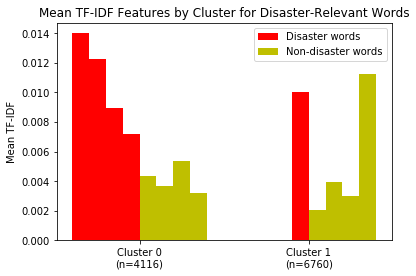

In [22]:
disaster_words = [
    'wildfire',
    'earthquake',
    'thunderstorm',
    'crash'
]

non_disaster_words = [
    'love',
    'obama',
    'summer',
    'movie'
]

disaster_indices = [vectorizer.vocabulary_[s] for s in disaster_words]
non_disaster_indices = [vectorizer.vocabulary_[s] for s in non_disaster_words]

plot_disaster_words_by_cluster(predicted, n_clusters, disaster_indices, non_disaster_indices)

In [15]:
n_clusters = 3
model = GaussianMixture(n_components=n_clusters, random_state=94775)
model.fit(X)
predicted = model.predict(X)

for i in range(n_clusters):
    print((predicted == i).sum())

1928
3377
5571


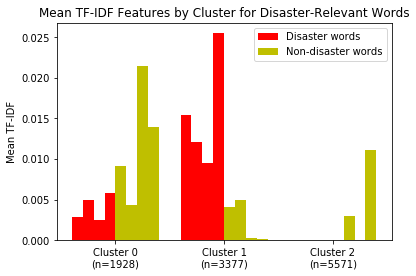

In [16]:
disaster_words = [
    'wildfire',
    'earthquake',
    'thunderstorm',
    'crash'
]

non_disaster_words = [
    'love',
    'obama',
    'summer',
    'movie'
]

disaster_indices = [vectorizer.vocabulary_[s] for s in disaster_words]
non_disaster_indices = [vectorizer.vocabulary_[s] for s in non_disaster_words]

plot_disaster_words_by_cluster(predicted, n_clusters, disaster_indices, non_disaster_indices)

In [17]:
n_clusters = 4
model = GaussianMixture(n_components=n_clusters, random_state=94775)
model.fit(X)
predicted = model.predict(X)

for i in range(n_clusters):
    print((predicted == i).sum())

1691
2899
2801
3485


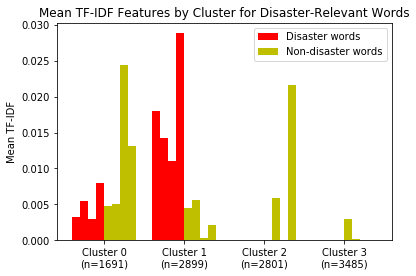

In [18]:
disaster_words = [
    'wildfire',
    'earthquake',
    'thunderstorm',
    'crash'
]

non_disaster_words = [
    'love',
    'obama',
    'summer',
    'movie'
]

disaster_indices = [vectorizer.vocabulary_[s] for s in disaster_words]
non_disaster_indices = [vectorizer.vocabulary_[s] for s in non_disaster_words]

plot_disaster_words_by_cluster(predicted, n_clusters, disaster_indices, non_disaster_indices)

In [19]:
n_clusters = 5
model = GaussianMixture(n_components=n_clusters, random_state=94775)
model.fit(X)
predicted = model.predict(X)

for i in range(n_clusters):
    print((predicted == i).sum())

1401
2488
2285
1302
3400


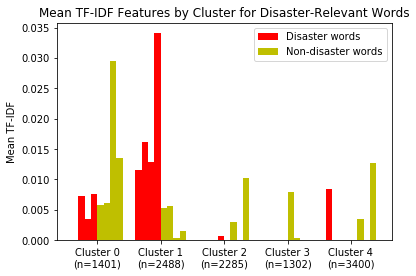

In [20]:
disaster_words = [
    'wildfire',
    'earthquake',
    'thunderstorm',
    'crash'
]

non_disaster_words = [
    'love',
    'obama',
    'summer',
    'movie'
]

disaster_indices = [vectorizer.vocabulary_[s] for s in disaster_words]
non_disaster_indices = [vectorizer.vocabulary_[s] for s in non_disaster_words]

plot_disaster_words_by_cluster(predicted, n_clusters, disaster_indices, non_disaster_indices)

Comparing the four plots, it seems that the best choice is n_clusters = 2, which works well in many cases.

Automatically choosing k (using a score function for each k):

In [19]:
from sklearn.metrics import calinski_harabaz_score
from sklearn.mixture import GaussianMixture

best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

for k in range(2, 11):
    candidate_gmm = GaussianMixture(n_components=k, random_state=94775)
    candidate_gmm.fit(X)
    cluster_assignments = candidate_gmm.predict(X)
    score = calinski_harabaz_score(X, cluster_assignments)
    
    print('k =', k, 'has CH index', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_gmm
        best_cluster_assignments = cluster_assignments
    
print('Best k within 2, 3, ..., 10 according to CH index:', best_k)

k = 2 has CH index 42.56221222653989
k = 3 has CH index 39.53039256345183
k = 4 has CH index 32.96218155309807
k = 5 has CH index 30.974340439814153
k = 6 has CH index 26.747667085847795
k = 7 has CH index 26.136150153461912
k = 8 has CH index 32.08072229545449
k = 9 has CH index 31.612166088083107
k = 10 has CH index 31.827027528217133
Best k within 2, 3, ..., 10 according to CH index: 2


(-0.058624551971326155,
 1.0586245519713262,
 -0.06287711552612213,
 1.0628771155261223)

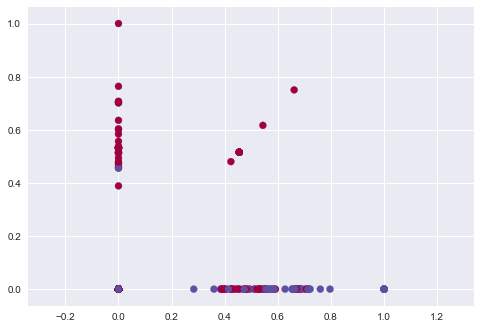

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

model = GaussianMixture(n_components=best_k, random_state=94775)
model.fit(X)
predicted = model.predict(X)
plt.scatter(X[:, 0], X[:, 1],c=best_cluster_assignments, cmap='Spectral')
plt.axis('equal')